# <span style="color:blue">Klasični pristup klasifikaciji slika limfnih čvorova</span>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import h5py

import pickle

from sklearn import preprocessing, model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from xgboost import XGBClassifier

from IPython.display import Image
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

### Učitavanje podataka iz hdf5 fajlova

In [2]:
hdf5_x_file = 'dataset/camelyonpatch_x.h5'
hdf5_y_file = 'dataset/camelyonpatch_y.h5'

hfx = h5py.File(hdf5_x_file, 'r')
hfy = h5py.File(hdf5_y_file, 'r')

X = hfx['x']
y = hfy['y']

print("X shape = ",X.shape)
print("y shape = ",y.shape)

X shape =  (32768, 96, 96, 3)
y shape =  (32768, 1, 1, 1)


In [3]:
X[:5]

array([[[[247, 246, 244],
         [246, 245, 243],
         [246, 245, 243],
         ...,
         [235, 236, 230],
         [251, 250, 248],
         [254, 254, 254]],

        [[247, 246, 244],
         [246, 245, 243],
         [246, 245, 243],
         ...,
         [247, 246, 244],
         [245, 243, 244],
         [245, 245, 247]],

        [[247, 246, 244],
         [246, 245, 243],
         [246, 245, 243],
         ...,
         [255, 254, 255],
         [243, 241, 244],
         [236, 235, 240]],

        ...,

        [[244, 244, 242],
         [244, 244, 242],
         [244, 244, 242],
         ...,
         [244, 242, 243],
         [245, 243, 244],
         [249, 245, 246]],

        [[243, 243, 241],
         [243, 243, 241],
         [244, 244, 242],
         ...,
         [242, 242, 242],
         [243, 241, 242],
         [245, 243, 244]],

        [[243, 243, 241],
         [243, 243, 241],
         [244, 244, 242],
         ...,
         [243, 243, 243],
        

In [4]:
y[:5]

array([[[[0]]],


       [[[1]]],


       [[[0]]],


       [[[1]]],


       [[[1]]]], dtype=uint8)

### Konvertovanje u np.array

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
#Reshape iz  4D u 2D

nsamples, nx, ny, nrgb = X.shape
X = X.reshape((nsamples,nx*ny*nrgb))
print('2D X shape = ',X.shape)

y = y.ravel()
print('2D y shape = ',y.shape)

2D X shape =  (32768, 27648)
2D y shape =  (32768,)


In [7]:
#Provera koliko u datasetu ima benignih i malignih uzoraka

benigni = np.sum(y==1)
print('Broj pozitivnih instanci dataseta: ', benigni)

maligni = np.sum(y==0)
print('Broj negativnih instanci dataseta: ', maligni)

Broj pozitivnih instanci dataseta:  16377
Broj negativnih instanci dataseta:  16391


### Podela dataseta na Training, Test i Validation set

In [8]:
X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_and_val, y_train_and_val, test_size = 0.25, random_state = 42, stratify = y_train_and_val )

In [9]:
print(X_train)

[[254 233 238 ... 151 120 128]
 [178 130 190 ... 174  70 169]
 [ 60  23 126 ... 167 103 199]
 ...
 [215 210 217 ... 242 179 250]
 [246 161 220 ... 121  49 161]
 [ 77  34  64 ... 128  85 105]]


In [10]:
print(y_train)

[0 1 1 ... 1 1 0]


In [11]:
print(X_test)

[[121  86 128 ... 252 252 252]
 [242 242 242 ... 193  68 208]
 [174 141 158 ... 115  63  65]
 ...
 [220 113 207 ... 227 217 242]
 [171  66 185 ... 238 223 255]
 [221 225 224 ... 187 126 186]]


In [12]:
print(y_test)

[1 1 0 ... 0 1 0]


In [13]:
print(X_validation)

[[241 229 241 ... 229 224 231]
 [227 161 223 ...  58  34 144]
 [173  85 127 ... 134  63  97]
 ...
 [121  89 165 ... 159  97 183]
 [ 76  46 146 ... 214 167 222]
 [184  68 169 ... 253 219 254]]


In [14]:
print(y_validation)

[0 0 1 ... 0 1 1]


In [15]:
print("Trening set (shape): ",X_train.shape)
print("Test set (shape): ",X_test.shape)
print("Validation set (shape): ",X_validation.shape)

Trening set (shape):  (19660, 27648)
Test set (shape):  (6554, 27648)
Validation set (shape):  (6554, 27648)


In [16]:
#Zbog velike količine iskorišćene memorije, oslobadja se deo koji nije više neophodan. 
#Nakon podele na train i test, mogu X i y da se uklone
del X, y

### Provera stratifikovanosti podataka za Training, Test i Validation set

In [17]:
benigni_train = np.sum(y_train==1)
print('Broj pozitivnih instanci trening seta: ', benigni_train)

maligni_train = np.sum(y_train==0)
print('Broj negativnih instanci trening seta: ', maligni_train)

Broj pozitivnih instanci trening seta:  9826
Broj negativnih instanci trening seta:  9834


In [18]:
benigni_test = np.sum(y_test==1)
print('Broj pozitivnih instanci test seta: ', benigni_test)
maligni_test = np.sum(y_test==0)
print('Broj negativnih instanci test seta: ', maligni_test)

Broj pozitivnih instanci test seta:  3276
Broj negativnih instanci test seta:  3278


In [19]:
benigni_val = np.sum(y_validation==1)
print('Broj pozitivnih instanci validacionog seta: ', benigni_val)
maligni_val = np.sum(y_validation==0)
print('Broj negativnih instanci validacionog seta: ', maligni_val)

Broj pozitivnih instanci validacionog seta:  3275
Broj negativnih instanci validacionog seta:  3279


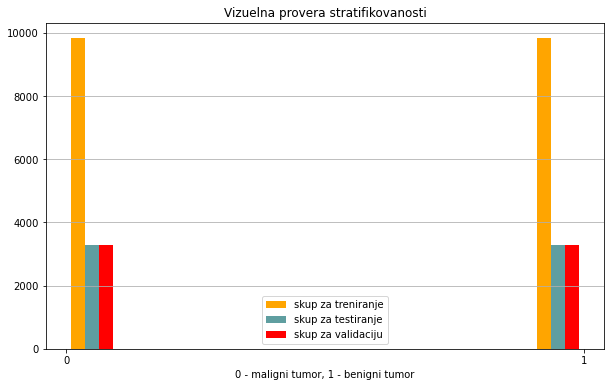

In [20]:
plt.figure(figsize = (10,6))

plt.title('Vizuelna provera stratifikovanosti')
plt.xticks([0,1])
plt.xlabel('0 - maligni tumor, 1 - benigni tumor')
plt.hist([y_train, y_test, y_validation], color=['orange', 'cadetblue', 'red'], label=['skup za treniranje', 'skup za testiranje', 'skup za validaciju'])
plt.legend(loc='best')
plt.grid(axis = 'y')

plt.savefig('assets/pictures/CM_StratificationCheck.jpg')

plt.show()

### Standardizacija

In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_validation = scaler.transform(X_validation)

In [22]:
scaler_tv = preprocessing.StandardScaler()
scaler_tv.fit(X_train_and_val)
X_train_and_val = scaler_tv.transform(X_train_and_val)
X_test = scaler_tv.transform(X_test)

In [23]:
print(X_train)

[[ 1.30910312  1.38902285  1.17899234 ... -0.39282128 -0.21108891
  -0.94294384]
 [ 0.08647567 -0.03866716  0.26224548 ... -0.02588697 -0.89542089
  -0.17817272]
 [-1.81181431 -1.52180144 -0.96008367 ... -0.13756263 -0.44376179
   0.38141591]
 ...
 [ 0.68170219  1.07021828  0.77791559 ...  1.05896227  0.59642281
   1.33271658]
 [ 1.1804055   0.39102595  0.83521227 ... -0.87143124 -1.18284032
  -0.32739635]
 [-1.53833186 -1.36932969 -2.14421502 ... -0.75975558 -0.6901213
  -1.37196179]]


In [24]:
print(X_test)

[[-0.82465962 -0.64608368 -0.9201372  ...  1.22047286  1.59752775
   1.3723488 ]
 [ 1.11346154  1.50732707  1.25023735 ...  0.28118425 -0.92216486
   0.55153983]
 [ 0.02426949  0.11313165 -0.348986   ... -0.96058714 -0.99063477
  -2.11608934]
 ...
 [ 0.76107588 -0.27337797  0.58389429 ...  0.82246921  1.11823839
   1.18580131]
 [-0.02378311 -0.92216198  0.16505007 ...  0.99759082  1.20040228
   1.42831305]
 [ 0.77709341  1.27266051  0.90754663 ...  0.18566337 -0.12791393
   0.14113534]]


In [25]:
print(X_validation)

[[ 1.09996948  1.33357857  1.23628902 ...  0.85156462  1.21232159
   0.97831045]
 [ 0.87474863  0.39102595  0.89250895 ... -1.87651215 -1.38813991
  -0.64449657]
 [ 0.00603966 -0.66241522 -0.94098477 ... -0.66403359 -0.99122736
  -1.52118542]
 ...
 [-0.83049491 -0.60697095 -0.21522684 ... -0.26519195 -0.52588162
   0.08296864]
 [-1.55441906 -1.20299688 -0.57810581 ...  0.61225964  0.43218314
   0.81043386]
 [ 0.18299889 -0.89805338 -0.13883127 ...  1.23445259  1.14388839
   1.4073284 ]]


### Čuvanje scaler-a

In [26]:
with open('assets/standard_scaler/Train.scaler.pickle', 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

In [27]:
with open('assets/standard_scaler/Train_and_Validation.scaler.pickle', 'wb') as scaler_file:
    pickle.dump(scaler_tv, scaler_file)

# <span style="color:blue">1. Logistička regresija</span>

In [28]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

### Predikcija na test setu

In [29]:
y_pred_log = log_reg.predict(X_test)

In [30]:
log_acc = accuracy_score(y_pred_log, y_test)
print('Tačnost: {0:.2f}%'.format(log_acc*100))

Tačnost: 64.28%


In [31]:
log_cr = classification_report(y_pred_log, y_test)
print(log_cr)

              precision    recall  f1-score   support

           0       0.63      0.65      0.64      3181
           1       0.66      0.64      0.65      3373

    accuracy                           0.64      6554
   macro avg       0.64      0.64      0.64      6554
weighted avg       0.64      0.64      0.64      6554



In [32]:
log_cm = confusion_matrix(y_pred_log, y_test)
log_cm

array([[2059, 1122],
       [1219, 2154]], dtype=int64)

### Predikcija na trening setu

In [33]:
y_pred_train_log = log_reg.predict(X_train)
print(y_pred_train_log)

[1 1 1 ... 1 1 0]


In [34]:
log_train_acc = accuracy_score(y_pred_train_log, y_train)
print('Tačnost: {0:.2f}%'.format(log_train_acc*100))

Tačnost: 95.99%


In [35]:
log_train_cr = classification_report(y_pred_train_log, y_train)
print(log_train_cr)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9833
           1       0.96      0.96      0.96      9827

    accuracy                           0.96     19660
   macro avg       0.96      0.96      0.96     19660
weighted avg       0.96      0.96      0.96     19660



In [36]:
log_train_cm = confusion_matrix(y_pred_train_log, y_train)
log_train_cm

array([[9439,  394],
       [ 395, 9432]], dtype=int64)

### Provera preprilagodjavanja

In [37]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(log_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(log_acc*100))

Tačnost na skupu za treniranje: 95.99%
Tačnost na skupu za testiranje: 64.28%


### Regularizacija zbog preprilagodjavanja

In [38]:
c = [0.0001, 0.001, 0.01, 0.1]
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

lr_acc = 0
best_c = 0
best_solver = ''
y_pred_lr = []
scores = {}
lr = None
for i in range(len(solver)):
    print("Solver = ", solver[i])
    for j in range(len(c)):
        print("\t C = ", c[j])

        model = LogisticRegression(C=c[j], solver = solver[i])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        print("\t\t Accuracy: ", acc)
        
        if solver[i] not in scores.keys():
            scores[solver[i]] = []
        
        scores[solver[i]].append(acc)
        if lr_acc < acc:
            lr_acc = acc
            best_c = c[j]
            best_solver = solver[i]
            y_pred_lr = y_pred
            lr = model

Solver =  newton-cg
	 C =  0.0001
		 Accuracy:  0.6924015868172109
	 C =  0.001
		 Accuracy:  0.6696673787000306
	 C =  0.01
		 Accuracy:  0.6502898992981385
	 C =  0.1
		 Accuracy:  0.6403722917302411
Solver =  lbfgs
	 C =  0.0001
		 Accuracy:  0.6924015868172109
	 C =  0.001
		 Accuracy:  0.6724137931034483
	 C =  0.01
		 Accuracy:  0.6576136710405859
	 C =  0.1
		 Accuracy:  0.6460176991150443
Solver =  liblinear
	 C =  0.0001
		 Accuracy:  0.6898077509917607
	 C =  0.001
		 Accuracy:  0.6699725358559658
	 C =  0.01
		 Accuracy:  0.6499847421422033
	 C =  0.1
		 Accuracy:  0.6406774488861764
Solver =  sag
	 C =  0.0001
		 Accuracy:  0.6927067439731461
	 C =  0.001
		 Accuracy:  0.6705828501678365
	 C =  0.01
		 Accuracy:  0.6605126640219713
	 C =  0.1
		 Accuracy:  0.6595971925541654
Solver =  saga
	 C =  0.0001
		 Accuracy:  0.6925541653951786
	 C =  0.001
		 Accuracy:  0.6718034787915776
	 C =  0.01
		 Accuracy:  0.6634116570033567
	 C =  0.1
		 Accuracy:  0.6618858712236801


In [39]:
print(lr)
print(best_solver)
print(best_c)
print(lr_acc)

LogisticRegression(C=0.0001, solver='sag')
sag
0.0001
0.6927067439731461


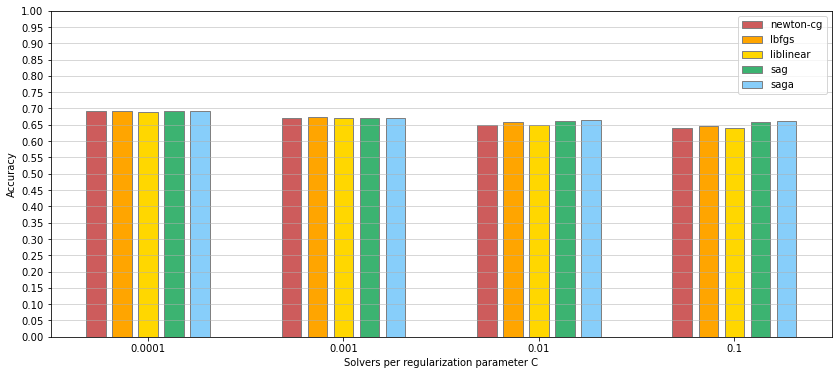

In [41]:
cmap = ['indianred', 'orange', 'gold', 'mediumseagreen', 'lightskyblue']
x_axis = np.arange(len(c))
move = [-2, -1, 0, 1, 2]
width = 0.2

plt.figure(figsize = (14,6))
for i in range(len(move)):
    plt.bar(x_axis + width*move[i]/1.5, scores[solver[i]], width = 0.1, color = cmap[i], edgecolor='gray')

plt.xticks(x_axis, c)
plt.yticks(np.linspace(0,1,21))

plt.xlabel("Solvers per regularization parameter C")
plt.ylabel("Accuracy")
plt.legend(solver)
plt.grid(axis='y', linewidth = 0.5)

plt.savefig("assets/pictures/CM_1_LR_best_parameters.jpg")

plt.show()


### Treniramo poboljšani model na train + validation setu

In [43]:
lr.fit(X_train_and_val, y_train_and_val)

LogisticRegression(C=0.0001, solver='sag')

In [44]:
best_y_pred_lr = lr.predict(X_test)
print(best_y_pred_lr)

[0 1 0 ... 1 1 1]


In [45]:
best_lr_acc = accuracy_score(best_y_pred_lr, y_test)
print('Tačnost: {0:.2f}%'.format(best_lr_acc*100))

Tačnost: 69.74%


In [46]:
best_lr_cr = classification_report(best_y_pred_lr, y_test)
print(best_lr_cr)

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      3465
           1       0.67      0.71      0.69      3089

    accuracy                           0.70      6554
   macro avg       0.70      0.70      0.70      6554
weighted avg       0.70      0.70      0.70      6554



In [47]:
best_lr_cm = confusion_matrix(best_y_pred_lr, y_test)
best_lr_cm

array([[2380, 1085],
       [ 898, 2191]], dtype=int64)

### Predikcija na trening + validation setu

In [48]:
y_pred_tv_blr = lr.predict(X_train_and_val)
print(y_pred_tv_blr)

[1 0 1 ... 1 0 0]


In [49]:
blr_tv_acc = accuracy_score(y_pred_tv_blr, y_train_and_val)
print('Tačnost: {0:.2f}%'.format(blr_tv_acc*100))

Tačnost: 78.77%


In [50]:
blr_tv_cr = classification_report(y_pred_tv_blr, y_train_and_val)
print(blr_tv_cr)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     13479
           1       0.77      0.80      0.78     12735

    accuracy                           0.79     26214
   macro avg       0.79      0.79      0.79     26214
weighted avg       0.79      0.79      0.79     26214



In [51]:
blr_tv_cm = confusion_matrix(y_pred_tv_blr, y_train_and_val)
blr_tv_cm

array([[10514,  2965],
       [ 2599, 10136]], dtype=int64)

### Provera popravke preprilagodjavanja

In [52]:
print('Tačnost na skupu za treniranje i validaciju: {0:.2f}%'.format(blr_tv_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(best_lr_acc*100))

Tačnost na skupu za treniranje i validaciju: 78.77%
Tačnost na skupu za testiranje: 69.74%


### ROC - AUC Kriva

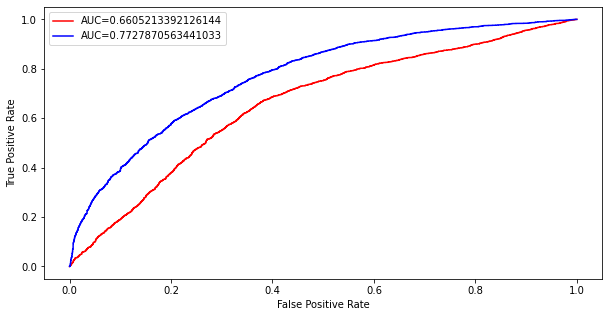

In [54]:
y_pred_proba_lr = log_reg.predict_proba(X_test)[::,1]
y_pred_proba_best_lr = lr.predict_proba(X_test)[::,1]

fpr_lr, tpr_lr, _ = roc_curve(y_test,  y_pred_proba_lr)
auc_lr = roc_auc_score(y_test, y_pred_proba_lr)

fpr_blr, tpr_blr, _ = roc_curve(y_test,  y_pred_proba_best_lr)
auc_blr = roc_auc_score(y_test,  y_pred_proba_best_lr)

plt.figure(figsize = (10,5))

plt.plot(fpr_lr,tpr_lr, color='red', label="AUC="+str(auc_lr))
plt.plot(fpr_blr,tpr_blr, color = 'blue', label="AUC="+str(auc_blr))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_1_LR_ROC_AUC_comparisson.jpg")

plt.show()

### Čuvanje modela logisticke regresije

In [55]:
with open('models/classic_models/lr_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(best_lr, model_file)

# <span style="color:blue">2. Model k-najbližih suseda</span>

### Provera najboljeg mogućeg koeficijenta k
Za vrednosti od 1 do 10 proveravamo koja bi vrednost koeficijenta k bila najbolja

In [56]:
k_range = list(range(1, 10))
scores = []
maks = 0
best_k = 0
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc) 
    if acc > maks and k!=1:
        maks = acc
        best_k = k

In [57]:
print('Parametar k sa najvecom preciznoscu: ', best_k)

Parametar k sa najvecom preciznoscu:  7


### Vizuelizacija odnosa preciznosti predikcije i vrednosti koeficijenta k

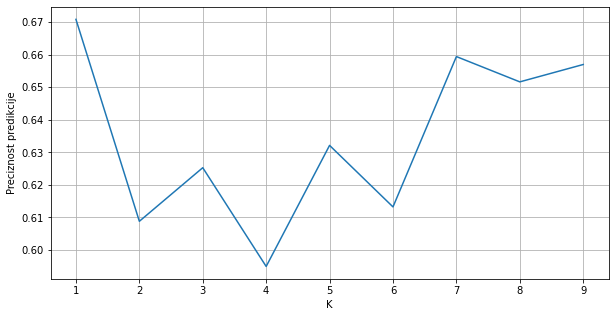

In [58]:
plt.figure(figsize = (10,5))

plt.xticks(np.linspace(0,10,11))
plt.xlabel('K')
plt.ylabel('Preciznost predikcije')
plt.grid()
plt.plot(k_range, scores)

plt.savefig("assets/pictures/CM_2_KNN_best_parameter_k.jpg")

plt.show()

### Predikcija na test setu

In [59]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [60]:
y_pred_knn = knn.predict(X_test)
print(y_pred_knn)

[0 1 1 ... 0 1 0]


In [61]:
knn_acc = accuracy_score(y_pred_knn,y_test)
print('Tačnost: {0:.2f}%'.format(knn_acc*100))

Tačnost: 65.94%


In [62]:
knn_cr = classification_report(y_pred_knn,y_test)
print(knn_cr)

              precision    recall  f1-score   support

           0       0.80      0.63      0.70      4180
           1       0.52      0.72      0.60      2374

    accuracy                           0.66      6554
   macro avg       0.66      0.67      0.65      6554
weighted avg       0.70      0.66      0.67      6554



In [63]:
knn_cm = confusion_matrix(y_pred_knn,y_test)
knn_cm

array([[2613, 1567],
       [ 665, 1709]], dtype=int64)

### Predikcija na trening setu

In [64]:
y_pred_train_knn = knn.predict(X_train)
print(y_pred_train_knn)

[0 1 1 ... 0 1 0]


In [65]:
knn_train_acc = accuracy_score(y_pred_train_knn, y_train)
print('Tačnost: {0:.2f}%'.format(knn_train_acc*100))

Tačnost: 73.43%


In [66]:
knn_train_cr = classification_report(y_pred_train_knn, y_train)
print(knn_train_cr)

              precision    recall  f1-score   support

           0       0.92      0.67      0.78     13398
           1       0.55      0.87      0.68      6262

    accuracy                           0.73     19660
   macro avg       0.73      0.77      0.73     19660
weighted avg       0.80      0.73      0.74     19660



In [67]:
knn_train_cm = confusion_matrix(y_pred_train_knn, y_train)
knn_train_cm

array([[9004, 4394],
       [ 830, 5432]], dtype=int64)

### Provera preprilagodjavanja

In [68]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(knn_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(knn_acc*100))

Tačnost na skupu za treniranje: 73.43%
Tačnost na skupu za testiranje: 65.94%


### ROC-AUC Kriva

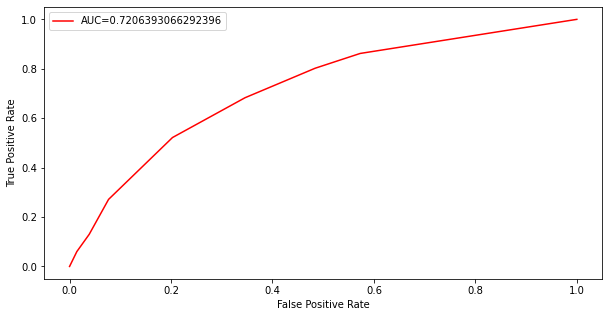

In [69]:
y_pred_proba_knn = knn.predict_proba(X_test)[::,1]

fpr_knn, tpr_knn, _ = roc_curve(y_test,  y_pred_proba_knn)
auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

plt.figure(figsize = (10,5))

plt.plot(fpr_knn,tpr_knn, color='red', label="AUC="+str(auc_knn))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_2_KNN_ROC_AUC.jpg")

plt.show()

### Čuvanje modela K najbližih suseda

In [70]:
with open('models/classic_models/knn_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(knn, model_file)

# <span style="color:blue">3. Stabla odlučivanja</span>

In [71]:
criterion = ['gini', 'entropy']
max_depth = [5,6,7,8,9]
dtc_acc = 0
best_depth = 0
dtc_criterion = ''
dtc = None
y_pred_dtc = []
scores = {}

for i in range(len(criterion)):
    print("Criterion = ", criterion[i])
    for j in range(len(max_depth)):
        print("\t max_depth=", max_depth[j])
        model = DecisionTreeClassifier(criterion = criterion[i], max_features=0.9, max_depth=max_depth[j], random_state=7)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_pred, y_test)
        print("\t\t Accuracy: ", acc)
        
        if criterion[i] not in scores.keys():
            scores[criterion[i]] = []
        
        scores[criterion[i]].append(acc)
        
        if dtc_acc < acc:
            best_criterion = criterion[i]
            best_depthp = max_depth[j]
            dtc_acc = acc
            dtc = model
            y_pred_dtc = y_pred

Criterion =  gini
	 max_depth= 5
		 Accuracy:  0.6780592004882514
	 max_depth= 6
		 Accuracy:  0.682636557827281
	 max_depth= 7
		 Accuracy:  0.6893500152578578
	 max_depth= 8
		 Accuracy:  0.7012511443393348
	 max_depth= 9
		 Accuracy:  0.7012511443393348
Criterion =  entropy
	 max_depth= 5
		 Accuracy:  0.6879768080561489
	 max_depth= 6
		 Accuracy:  0.6817210863594751
	 max_depth= 7
		 Accuracy:  0.6925541653951786
	 max_depth= 8
		 Accuracy:  0.6953005797985963
	 max_depth= 9
		 Accuracy:  0.6919438510833079


In [95]:
scores

{'gini': [0.6780592004882514,
  0.682636557827281,
  0.6893500152578578,
  0.7012511443393348,
  0.7012511443393348],
 'entropy': [0.6879768080561489,
  0.6817210863594751,
  0.6925541653951786,
  0.6953005797985963,
  0.6919438510833079]}

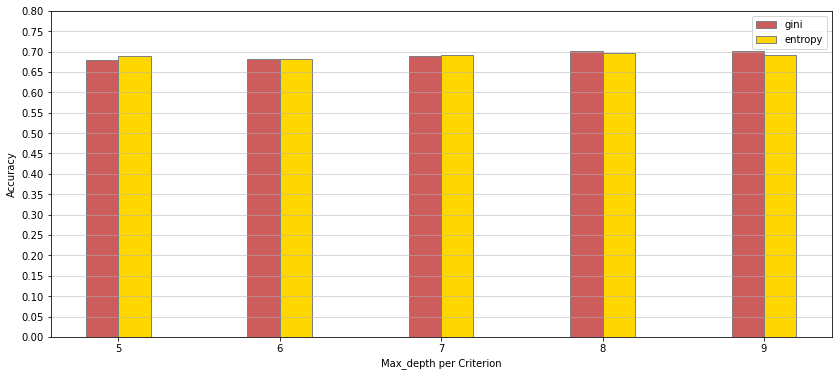

In [97]:
cmap = ['indianred', 'gold']
x_axis = np.arange(len(max_depth))
move = [-1/2, 1/2]
width = 0.2

plt.figure(figsize = (10,6))
for i in range(len(move)):
    plt.bar(x_axis + width*move[i], scores[criterion[i]], width = width, color = cmap[i], edgecolor='gray')

plt.xticks(x_axis, max_depth)
plt.yticks(np.linspace(0,0.8,17))

plt.xlabel("Max_depth per Criterion")
plt.ylabel("Accuracy")
plt.legend(criterion)
plt.grid(axis='y', linewidth = 0.5)

plt.savefig("assets/pictures/CM_1_DTC_best_parameters.jpg")

plt.show()

### Predikcija na test setu

In [98]:
dtc

DecisionTreeClassifier(max_depth=8, max_features=0.9, random_state=7)

In [99]:
y_pred_dtc

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [100]:
print('Tačnost: {0:.2f}%'.format(dtc_acc*100))

Tačnost: 70.13%


In [101]:
dtc_cr = classification_report(y_pred_dtc, y_test)
print(dtc_cr)

              precision    recall  f1-score   support

           0       0.59      0.76      0.67      2572
           1       0.81      0.67      0.73      3982

    accuracy                           0.70      6554
   macro avg       0.70      0.71      0.70      6554
weighted avg       0.72      0.70      0.70      6554



### Predikcija na trening setu

In [102]:
y_pred_train_dtc = dtc.predict(X_train)
print(y_pred_train_dtc)

[1 1 1 ... 1 1 1]


In [103]:
dtc_train_acc = accuracy_score(y_pred_train_dtc, y_train)
print('Tačnost: {0:.2f}%'.format(dtc_train_acc*100))

Tačnost: 78.39%


In [104]:
dtc_train_cr = classification_report(y_pred_train_dtc, y_train)
print(dtc_train_cr)

              precision    recall  f1-score   support

           0       0.67      0.86      0.76      7681
           1       0.89      0.73      0.81     11979

    accuracy                           0.78     19660
   macro avg       0.78      0.80      0.78     19660
weighted avg       0.81      0.78      0.79     19660



In [105]:
dtc_train_cm = confusion_matrix(y_pred_train_dtc, y_train)
print(dtc_train_cm)

[[6633 1048]
 [3201 8778]]


### Provera preprilagodjavanja

In [106]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(dtc_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(dtc_acc*100))

Tačnost na skupu za treniranje: 78.39%
Tačnost na skupu za testiranje: 70.13%


### ROC-AUC Kriva

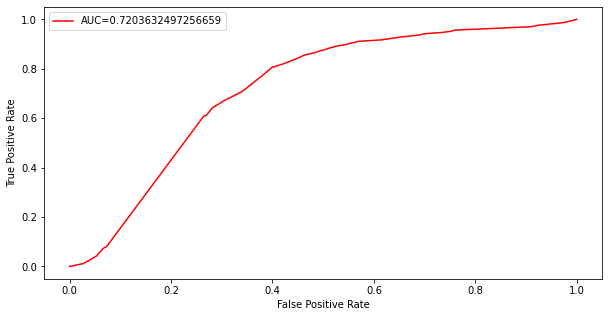

In [107]:
y_pred_proba_dtc = dtc.predict_proba(X_test)[::,1]

fpr_dtc, tpr_dtc, _ = roc_curve(y_test,  y_pred_proba_dtc)
auc_dtc = roc_auc_score(y_test, y_pred_proba_dtc)

plt.figure(figsize = (10,5))

plt.plot(fpr_dtc, tpr_dtc, color='red', label="AUC="+str(auc_dtc))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_3_DTC_ROC_AUC.jpg")

plt.show()

### Čuvanje modela stabla odlučivanja

In [108]:
with open('models/classic_models/dtc_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(dtc, model_file)

# <span style="color:blue">4. Slučajne šume</span>

In [109]:
rf = RandomForestClassifier(n_estimators = 20, max_depth = 3, random_state = 7)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=20, random_state=7)

### Predikcija na test setu

In [110]:
y_pred_rf = rf.predict(X_test)
print(y_pred_rf)

[1 1 1 ... 1 1 0]


In [111]:
rf_acc = accuracy_score(y_pred_rf, y_test)
print('Tačnost: {0:.2f}%'.format(rf_acc*100))

Tačnost: 70.95%


In [112]:
rf_cr = classification_report(y_pred_rf, y_test)
print(rf_cr)

              precision    recall  f1-score   support

           0       0.55      0.80      0.66      2258
           1       0.87      0.66      0.75      4296

    accuracy                           0.71      6554
   macro avg       0.71      0.73      0.70      6554
weighted avg       0.76      0.71      0.72      6554



In [113]:
rf_cm = confusion_matrix(y_pred_rf, y_test)
rf_cm

array([[1816,  442],
       [1462, 2834]], dtype=int64)

### Predikcija na trening setu

In [114]:
y_pred_train_rf = rf.predict(X_train)
print(y_pred_train_rf)

[1 1 1 ... 1 1 0]


In [115]:
rf_train_acc = accuracy_score(y_pred_train_rf, y_train)
print('Tačnost: {0:.2f}%'.format(rf_train_acc*100))

Tačnost: 71.25%


In [116]:
rf_train_cr = classification_report(y_pred_train_rf, y_train)
print(rf_train_cr)

              precision    recall  f1-score   support

           0       0.55      0.82      0.66      6590
           1       0.88      0.66      0.75     13070

    accuracy                           0.71     19660
   macro avg       0.71      0.74      0.70     19660
weighted avg       0.77      0.71      0.72     19660



In [117]:
rf_train_cr = classification_report(y_pred_train_rf, y_train)
print(rf_train_cr)

              precision    recall  f1-score   support

           0       0.55      0.82      0.66      6590
           1       0.88      0.66      0.75     13070

    accuracy                           0.71     19660
   macro avg       0.71      0.74      0.70     19660
weighted avg       0.77      0.71      0.72     19660



### Provera_preprilagodjavanja

In [118]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(rf_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(rf_acc*100))

Tačnost na skupu za treniranje: 71.25%
Tačnost na skupu za testiranje: 70.95%


### Pokušaj da se dobiju malo bolji rezultati 

In [119]:
criterion = ['gini', 'entropy']
max_depth = [5,6,7,8,9]
n_estimators = [20,50,100]
rfc_acc = 0
best_criterion = ''
best_depth = 0
best_estimator = 0
rfc = None
y_pred_rfc = []
for i in range(len(criterion)):
    print("criterion: {}".format(criterion[i]))
    for j in range(len(max_depth)):
        print("\t max_depth: {}".format(max_depth[j]))
        for k in range(len(n_estimators)):
            print("\t\t n_estimators: {}".format(n_estimators[k]))
            model = RandomForestClassifier(criterion = criterion[i], n_estimators = n_estimators[k], max_depth = max_depth[j], random_state = 7)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_pred, y_test)
            print('\t\t\t Accuracy: {}'.format(acc))
            if dtc_acc < acc:
                best_criterion = criterion[i]
                best_depth = max_depth[j]
                best_estimator = n_estimators[k]
                rfc_acc = acc
                rfc = model
                y_pred_rfc = y_pred

criterion: gini
	 max_depth: 5
		 n_estimators: 20
			 Accuracy: 0.7349710100701862
		 n_estimators: 50
			 Accuracy: 0.7459566676838572
		 n_estimators: 100
			 Accuracy: 0.7497711321330485
	 max_depth: 6
		 n_estimators: 20
			 Accuracy: 0.7456515105279219
		 n_estimators: 50
			 Accuracy: 0.747329874885566
		 n_estimators: 100
			 Accuracy: 0.7540433323161428
	 max_depth: 7
		 n_estimators: 20
			 Accuracy: 0.7491608178211779
		 n_estimators: 50
			 Accuracy: 0.7551113823619164
		 n_estimators: 100
			 Accuracy: 0.7577052181873665
	 max_depth: 8
		 n_estimators: 20
			 Accuracy: 0.7509917607567898
		 n_estimators: 50
			 Accuracy: 0.7569423252975283
		 n_estimators: 100
			 Accuracy: 0.7621299969484284
	 max_depth: 9
		 n_estimators: 20
			 Accuracy: 0.7561794324076899
		 n_estimators: 50
			 Accuracy: 0.7642660970399756
		 n_estimators: 100
			 Accuracy: 0.7659444613976197
criterion: entropy
	 max_depth: 5
		 n_estimators: 20
			 Accuracy: 0.7450411962160512
		 n_estimators: 50
			

In [120]:
print('best max_depth: ',best_depth)
print('best n_estimators: ',best_estimator)

best max_depth:  9
best n_estimators:  100


In [121]:
print('Tačnost: {0:.2f}%'.format(rfc_acc*100))

Tačnost: 76.69%


### Treniramo poboljšani model na train + validation setu

In [122]:
rfc

RandomForestClassifier(criterion='entropy', max_depth=9, random_state=7)

In [123]:
rfc.fit(X_train_and_val, y_train_and_val)

RandomForestClassifier(criterion='entropy', max_depth=9, random_state=7)

### Predikcija na test setu


In [124]:
best_y_pred_rfc = rfc.predict(X_test)
print(best_y_pred_rfc)

[1 1 1 ... 1 1 1]


In [125]:
best_rfc_acc = accuracy_score(best_y_pred_rfc, y_test)
print('Tačnost: {0:.2f}%'.format(best_rfc_acc*100))

Tačnost: 77.11%


In [126]:
best_rfc_cr = classification_report(best_y_pred_rfc, y_test)
print(best_rfc_cr)

              precision    recall  f1-score   support

           0       0.67      0.84      0.74      2600
           1       0.87      0.72      0.79      3954

    accuracy                           0.77      6554
   macro avg       0.77      0.78      0.77      6554
weighted avg       0.79      0.77      0.77      6554



In [127]:
best_rfc_cm = confusion_matrix(best_y_pred_rfc, y_test)
best_rfc_cm

array([[2189,  411],
       [1089, 2865]], dtype=int64)

### Predikcija na  train + validation setu

In [128]:
y_pred_tv_brfc = rfc.predict(X_train_and_val)
print(y_pred_tv_brfc)

[1 1 1 ... 1 0 1]


In [129]:
brfc_tv_acc = accuracy_score(y_pred_tv_brfc, y_train_and_val)
print('Tačnost: {0:.2f}%'.format(brfc_tv_acc*100))

Tačnost: 85.72%


In [130]:
brfc_tv_cr = classification_report(y_pred_tv_brfc, y_train_and_val)
print(brfc_tv_cr)

              precision    recall  f1-score   support

           0       0.74      0.97      0.84     10062
           1       0.97      0.79      0.87     16152

    accuracy                           0.86     26214
   macro avg       0.86      0.88      0.86     26214
weighted avg       0.88      0.86      0.86     26214



In [131]:
brfc_tv_cm = confusion_matrix(y_pred_tv_brfc, y_train_and_val)
brfc_tv_cm

array([[ 9716,   346],
       [ 3397, 12755]], dtype=int64)

### Provera preprilagodjavanja

In [132]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(brfc_tv_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(best_rfc_acc*100))

Tačnost na skupu za treniranje: 85.72%
Tačnost na skupu za testiranje: 77.11%


### ROC-AUC Kriva

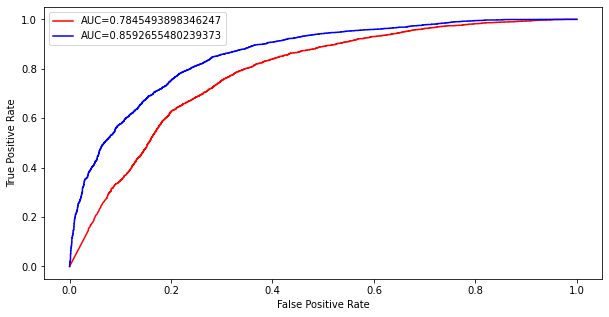

In [133]:
y_pred_proba_rf = rf.predict_proba(X_test)[::,1]
y_pred_proba_brfc = rfc.predict_proba(X_test)[::,1]

fpr_rf, tpr_rf, _ = roc_curve(y_test,  y_pred_proba_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

fpr_brfc, tpr_brfc, _ = roc_curve(y_test,  y_pred_proba_brfc)
auc_brfc = roc_auc_score(y_test,  y_pred_proba_brfc)

plt.figure(figsize = (10,5))

plt.plot(fpr_rf, tpr_rf, color='red', label="AUC="+str(auc_rf))
plt.plot(fpr_brfc,tpr_brfc, color = 'blue', label="AUC="+str(auc_brfc))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_4_RF_ROC_AUC_comparisson.jpg")

plt.show()

### Čuvanje modela slučajne šume

In [134]:
with open('models/classic_models/rf_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(rfc, model_file)

# <span style="color:blue">5. Naivni Bayes</span>

In [135]:
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

### Predikcija na test setu

In [136]:
y_pred_nb = nb.predict(X_test)
print(y_pred_nb)

[0 1 1 ... 1 1 1]


In [137]:
nb_acc = accuracy_score(y_pred_nb,y_test)
print('Tačnost: {0:.2f}%'.format(nb_acc*100))

Tačnost: 65.97%


In [138]:
nb_cr = classification_report(y_pred_nb,y_test)
print(nb_cr)

              precision    recall  f1-score   support

           0       0.56      0.70      0.62      2648
           1       0.76      0.63      0.69      3906

    accuracy                           0.66      6554
   macro avg       0.66      0.67      0.66      6554
weighted avg       0.68      0.66      0.66      6554



In [139]:
nb_cm = confusion_matrix(y_pred_nb,y_test)
print(nb_cm)

[[1848  800]
 [1430 2476]]


### Predikcija na trening setu

In [140]:
y_pred_train_nb = nb.predict(X_train)
print(y_pred_train_nb)

[0 1 1 ... 1 1 1]


In [141]:
nb_train_acc = accuracy_score(y_pred_train_nb,y_train)
print('Tačnost: {0:.2f}%'.format(nb_train_acc*100))

Tačnost: 65.51%


In [142]:
nb_train_cr = classification_report(y_pred_train_nb,y_train)
print(nb_train_cr)

              precision    recall  f1-score   support

           0       0.55      0.70      0.61      7761
           1       0.76      0.63      0.69     11899

    accuracy                           0.66     19660
   macro avg       0.66      0.66      0.65     19660
weighted avg       0.68      0.66      0.66     19660



In [143]:
nb_train_cm = confusion_matrix(y_pred_train_nb,y_train)
print(nb_train_cm)

[[5407 2354]
 [4427 7472]]


### Provera preprilagodjavanja

In [144]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(nb_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(nb_acc*100))

Tačnost na skupu za treniranje: 65.51%
Tačnost na skupu za testiranje: 65.97%


### ROC-AUC Kriva

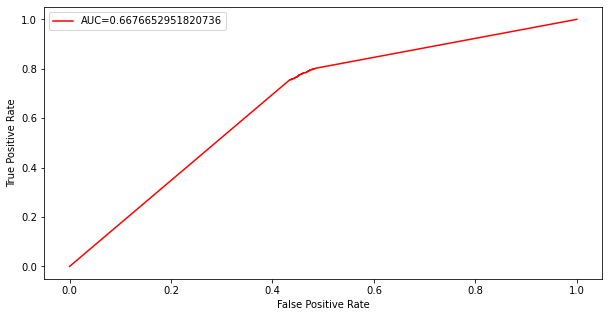

In [145]:
y_pred_proba_nb = nb.predict_proba(X_test)[::,1]

fpr_nb, tpr_nb, _ = roc_curve(y_test,  y_pred_proba_nb)
auc_nb = roc_auc_score(y_test, y_pred_proba_nb)

plt.figure(figsize = (10,5))

plt.plot(fpr_nb, tpr_nb, color='red', label="AUC="+str(auc_nb))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_5_NB_ROC_AUC.jpg")

plt.show()

### Čuvanje modela NB

In [146]:
with open('models/classic_models/nb_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(nb, model_file)

# <span style="color:blue">6. Metod potpornih vektora</span>

In [147]:
sv = SVC(kernel = 'rbf', random_state = 0)
sv.fit(X_train, y_train)

SVC(random_state=0)

### Predikcija na test setu

In [148]:
y_pred_svc = sv.predict(X_test)
print(y_pred_svc)

[1 1 1 ... 1 1 1]


In [149]:
svc_acc = accuracy_score(y_pred_svc, y_test)
print('Tačnost: {0:.2f}%'.format(svc_acc*100))

Tačnost: 80.44%


svc_cr = classification_report(y_pred_svc, y_test)
print(svc_cr)

In [150]:
svc_cm = confusion_matrix(y_pred_svc, y_test)
print(svc_cm)

[[2607  611]
 [ 671 2665]]


### Predikcija na trening setu

In [151]:
y_pred_train_svc = sv.predict(X_train)
print(y_pred_train_svc)

[0 1 1 ... 1 1 0]


In [152]:
svc_train_acc = accuracy_score(y_pred_train_svc, y_train)
print('Tačnost: {0:.2f}%'.format(svc_train_acc*100))

Tačnost: 93.07%


In [153]:
svc_train_cr = classification_report(y_pred_train_svc, y_train)
print(svc_train_cr)

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      9625
           1       0.94      0.92      0.93     10035

    accuracy                           0.93     19660
   macro avg       0.93      0.93      0.93     19660
weighted avg       0.93      0.93      0.93     19660



In [154]:
svc_train_cm = confusion_matrix(y_pred_train_svc, y_train)
print(svc_train_cm)

[[9048  577]
 [ 786 9249]]


### Provera preprilagodjavanja

In [155]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(svc_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(svc_acc*100))

Tačnost na skupu za treniranje: 93.07%
Tačnost na skupu za testiranje: 80.44%


<!-- ### K-fold unakrsna validacija -->

In [156]:
# accuracies = cross_val_score(estimator = svc, X = X_train, y = y_train, cv = 10)
# print("Tačnost: ",accuracies.mean()*100)
# print("Standardna devijacija: ",accuracies.std()*100)

# print(accuracies)

<!-- ### Traženje malo boljih parametara -->

In [ ]:
# c = [0.001, 0.01, 0.1, 1, 10, 100]
# gamma = [0.001, 0.01, 0.1, 1, 10, 100]
    
# svc_acc = 0
# best_c = 0
# best_gamma = 0
# y_pred_svc = []
# scores = {}

# svc = None
# for i in range(len(c)):
#     print('C = ', c[i])
#     for j in range(len(gamma)):
#         print('\t Gamma: ',gamma[j])

#         model = SVC(kernel = 'rbf', C=c[i], gamma=gamma[j])
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         acc = accuracy_score(y_pred, y_test)
#         print('\t\t Accuracy: ',acc)
        
#         if c[i] not in scores.keys():
#             scores[c[i]] = []
            
#         scores[c[i]].append(acc)
        
#         if svc_acc < acc:
#             svc_acc = acc
#             best_c = c[i]
#             best_gamma = gamma[j]
#             y_pred_svc = y_pred
#             svc = model

C =  0.001
	 Gamma:  0.001


In [ ]:
# print(scores)

In [ ]:
# plt.figure(figsize = (10,10))

# plt.imshow((gamma,c), cmap = 'coolwarm')

# plt.colorbar()

# # Odradi reshape za scores pa nastavi!

# # plt.xticks(np.arrage(0, len(c), c))
# # plt.yticks(np.arrage(0, len(gamma), gamma))

# # plt.xlabel("Gamma")
# # plt.ylabel("C")

# # plt.savefig("assets/pictures/CM_7_SVC_best_parameters.jpg")

# # plt.show()

In [ ]:
# print('Best C = ',best_c)
# print('Best Gamma = ', best_gamma)

In [ ]:
# print('Tačnost: {0:.2f}%'.format(svc_acc*100))

<!-- ### Treniramo poboljšani model na train + validation setu -->

In [ ]:
# svc

In [ ]:
# svc.fit(X_train_and_val, y_train_and_val)

<!-- ### Predikcija na test setu -->

In [ ]:
# best_y_pred_svc = svc.predict(X_test)
# print(best_y_pred_svc)

In [ ]:
# best_svc_acc = accuracy_score(best_y_pred_svc, y_test)
# print('Tačnost: {0:.2f}%'.format(best_svc_acc*100))

In [ ]:
# best_svc_cr = classification_report(best_y_pred_svc, y_test)
# print(best_svc_cr)

In [ ]:
# best_svc_cm = confusion_matrix(best_y_pred_svc, y_test)
# best_svc_cm

<!-- ### Predikcija na train + validation setu -->

In [ ]:
# y_pred_tv_bsvc = svc.predict(X_train_and_val)
# print(y_pred_tv_bsvc)

In [ ]:
# bsvc_tv_acc = accuracy_score(y_pred_tv_bsvc, y_train_and_val)
# print('Tačnost: {0:.2f}%'.format(bsvc_tv_acc*100))

In [ ]:
# bsvc_tv_cr = classification_report(y_pred_tv_bsvc, y_train_and_val)
# print(bsvc_tv_cr)

In [ ]:
# bsvc_tv_cm = confusion_matrix(y_pred_tv_bsvc, y_train_and_val)
# bsvc_tv_cm

<!-- ### Provera preprilagodjavanja nakon popravke -->

In [ ]:
# print('Tačnost na skupu za treniranje: {0:.2f}%'.format(bsvc_tv_acc*100))
# print('Tačnost na skupu za testiranje: {0:.2f}%'.format(best_svc_acc*100))

<!-- ### ROC-AUC Kriva -->

In [ ]:
# y_pred_proba_sv = sv.predict_proba(X_test)[::,1]
# y_pred_proba_bsvc = svc.predict_proba(X_test)[::,1]

# fpr_sv, tpr_sv, _ = roc_curve(y_test,  y_pred_proba_sv)
# auc_sv = roc_auc_score(y_test, y_pred_proba_sv)

# fpr_bsvc, tpr_svc, _ = roc_curve(y_test,  y_pred_proba_bsvc)
# auc_bsvc = roc_auc_score(y_test,  y_pred_proba_bsvc)

# plt.figure(figsize = (10,5))

# plt.plot(fpr_sv, tpr_sv, color='red', label="AUC="+str(auc_sv))
# plt.plot(fpr_bsvc,tpr_bsvc, color = 'blue', label="AUC="+str(auc_bsvc))

# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.legend()

# plt.savefig("assets/pictures/CM_6_SVC_ROC_AUC_comparisson.jpg")

# plt.show()

### Čuvanje modela potpornih vektora

In [178]:
with open('models/classic_models/svc_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(sv, model_file)

# <span style="color:blue">7. Pojačavanje</span>

## 7.1 AdaBoost

In [165]:
ab = AdaBoostClassifier(base_estimator = dtc)
ab.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                         max_features=0.9,
                                                         random_state=7))

### Predikcija na test setu

In [166]:
y_pred_ab = ab.predict(X_test)
print(y_pred_ab)

[1 0 1 ... 1 1 1]


In [167]:
ab_acc = accuracy_score(y_pred_ab, y_test)
print('Tačnost: {0:.2f}%'.format(ab_acc*100))

Tačnost: 72.31%


In [168]:
ab_cr = classification_report(y_pred_ab, y_test)
print(ab_cr)

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      3165
           1       0.74      0.72      0.73      3389

    accuracy                           0.72      6554
   macro avg       0.72      0.72      0.72      6554
weighted avg       0.72      0.72      0.72      6554



In [169]:
ab_cm = confusion_matrix(y_pred_ab, y_test)
print(ab_cm)

[[2314  851]
 [ 964 2425]]


### Predikcija na trening setu

In [170]:
y_pred_tv_ab = ab.predict(X_train)
print(y_pred_tv_ab)

[0 1 1 ... 1 1 0]


In [171]:
ab_train_acc = accuracy_score(y_pred_tv_ab, y_train)
print('Tačnost: {0:.2f}%'.format(ab_train_acc*100))

Tačnost: 100.00%


In [172]:
ab_train_cr = classification_report(y_pred_tv_ab, y_train)
print(ab_train_cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9834
           1       1.00      1.00      1.00      9826

    accuracy                           1.00     19660
   macro avg       1.00      1.00      1.00     19660
weighted avg       1.00      1.00      1.00     19660



In [173]:
ab_train_cm = confusion_matrix(y_pred_tv_ab, y_train)
print(ab_train_cm)

[[9834    0]
 [   0 9826]]


### Provera preprilagodjavanja

In [174]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(ab_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(ab_acc*100))

Tačnost na skupu za treniranje: 100.00%
Tačnost na skupu za testiranje: 72.31%


Model je **preprilagodjen**, ali neće biti popravljan. 

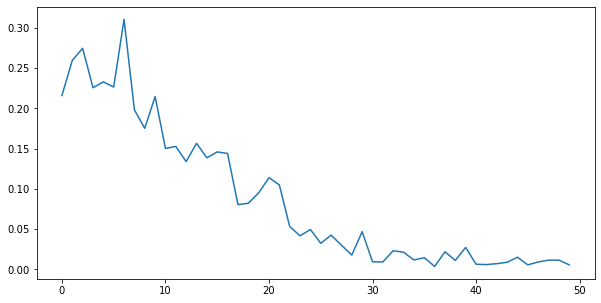

In [175]:
plt.figure(figsize = (10,5))
plt.plot(range(0, ab.n_estimators), ab.estimator_errors_)

plt.savefig()
plt.show()

### ROC-AUC Kriva

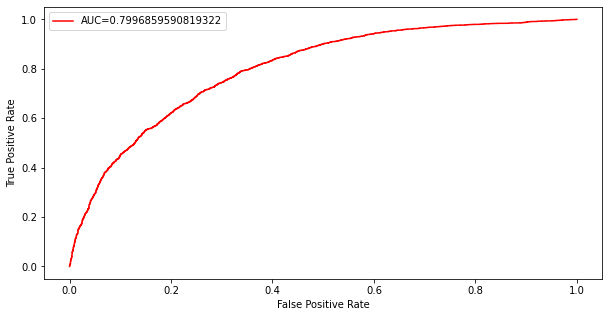

In [177]:
y_pred_proba_ab = ab.predict_proba(X_test)[::,1]

fpr_ab, tpr_ab, _ = roc_curve(y_test,  y_pred_proba_ab)
auc_ab = roc_auc_score(y_test,  y_pred_proba_ab)

plt.figure(figsize = (10,5))

plt.plot(fpr_ab, tpr_ab, color='red', label="AUC="+str(auc_ab))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_7_AB_ROC_AUC.jpg")

plt.show()

### Čuvanje modela Ada Boost

In [179]:
with open('models/classic_models/ab_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(ab, model_file)

## 7.2 XGBoost

In [180]:
xgb = XGBClassifier(use_label_encoder=False)
xgb.fit(X_train, y_train)

[13:55:12] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Predikcija na test setu

In [181]:
y_pred_xgb = xgb.predict(X_test)
print(y_pred_xgb)

[1 1 1 ... 1 1 1]


In [182]:
xgb_acc = accuracy_score(y_pred_xgb, y_test)
print('Tačnost: {0:.2f}%'.format(xgb_acc*100))

Tačnost: 79.72%


In [183]:
xgb_cr = classification_report(y_pred_xgb, y_test)
print(xgb_cr)

              precision    recall  f1-score   support

           0       0.78      0.81      0.79      3185
           1       0.81      0.79      0.80      3369

    accuracy                           0.80      6554
   macro avg       0.80      0.80      0.80      6554
weighted avg       0.80      0.80      0.80      6554



In [184]:
xgb_cm = confusion_matrix(y_pred_xgb, y_test)
print(xgb_cm)

[[2567  618]
 [ 711 2658]]


### Predikcija na trening setu

In [185]:
y_train_pred_xgb = xgb.predict(X_train)
print(y_train_pred_xgb)

[0 1 1 ... 1 1 0]


In [186]:
xgb_train_acc = accuracy_score(y_train_pred_xgb, y_train)
print('Tačnost: {0:.2f}%'.format(xgb_train_acc*100))

Tačnost: 99.94%


In [187]:
xgb_train_cr = classification_report(y_train_pred_xgb, y_train)
print(xgb_train_cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9838
           1       1.00      1.00      1.00      9822

    accuracy                           1.00     19660
   macro avg       1.00      1.00      1.00     19660
weighted avg       1.00      1.00      1.00     19660



In [188]:
xgb_train_cm = confusion_matrix(y_train_pred_xgb, y_train)
print(xgb_train_cm)

[[9830    8]
 [   4 9818]]


### Provera preprilagodjavanja

In [189]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(xgb_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(xgb_acc*100))

Tačnost na skupu za treniranje: 99.94%
Tačnost na skupu za testiranje: 79.72%


Model je **preprilagodjen**, ali neće biti popravljan. 

### ROC-AUC kriva

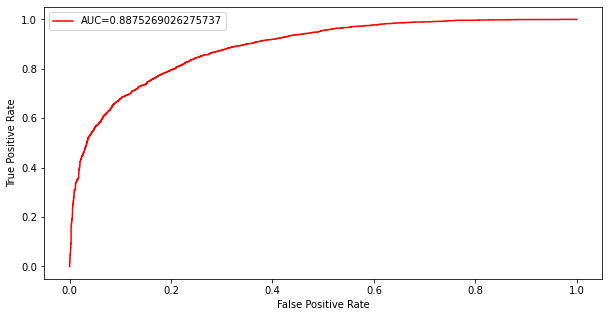

In [211]:
y_pred_proba_xgb = xgb.predict_proba(X_test)[::,1]

fpr_xgb, tpr_xgb, _ = roc_curve(y_test,  y_pred_proba_xgb)
auc_xgb = roc_auc_score(y_test,  y_pred_proba_xgb)

plt.figure(figsize = (10,5))

plt.plot(fpr_xgb, tpr_xgb, color='red', label="AUC="+str(auc_xgb))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_7_XGB_ROC_AUC.jpg")

plt.show()

### Čuvanje modela XGBoost

In [190]:
with open('models/classic_models/xgb_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(xgb, model_file)

# <span style="color:blue">8. Prosta agregacija</span>

In [191]:
bag = BaggingClassifier(dtc, n_estimators=500, max_samples=100, bootstrap=True, random_state=7)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=8,
                                                        max_features=0.9,
                                                        random_state=7),
                  max_samples=100, n_estimators=500, random_state=7)

### Predikcija na test setu

In [192]:
y_pred_bag = bag.predict(X_test)
print(y_pred_bag)

[1 1 1 ... 1 1 1]


In [193]:
bag_acc = accuracy_score(y_pred_bag, y_test)
print('Tačnost: {0:.2f}%'.format(bag_acc*100))

Tačnost: 74.05%


In [194]:
bag_cr = classification_report(y_pred_bag, y_test)
print(bag_cr)

              precision    recall  f1-score   support

           0       0.69      0.76      0.73      2979
           1       0.79      0.72      0.75      3575

    accuracy                           0.74      6554
   macro avg       0.74      0.74      0.74      6554
weighted avg       0.74      0.74      0.74      6554



In [195]:
bag_cm = confusion_matrix(y_pred_bag, y_test)
print(bag_cm)

[[2278  701]
 [1000 2575]]


### Predikcija na trening setu

In [196]:
y_train_pred_bag = bag.predict(X_train)
print(y_train_pred_bag)

[0 1 1 ... 1 1 0]


In [197]:
bag_train_acc = accuracy_score(y_train_pred_bag, y_train)
print('Tačnost: {0:.2f}%'.format(bag_train_acc*100))

Tačnost: 74.03%


In [198]:
bag_train_cr = classification_report(y_train_pred_bag, y_train)
print(bag_train_cr)

              precision    recall  f1-score   support

           0       0.69      0.77      0.73      8781
           1       0.79      0.72      0.75     10879

    accuracy                           0.74     19660
   macro avg       0.74      0.74      0.74     19660
weighted avg       0.75      0.74      0.74     19660



In [199]:
bag_train_cm = confusion_matrix(y_train_pred_bag, y_train)
print(bag_train_cm)

[[6755 2026]
 [3079 7800]]


### Provera preprilagodjavanja

In [200]:
print('Tačnost na skupu za treniranje: {0:.2f}%'.format(bag_train_acc*100))
print('Tačnost na skupu za testiranje: {0:.2f}%'.format(bag_acc*100))

Tačnost na skupu za treniranje: 74.03%
Tačnost na skupu za testiranje: 74.05%


### ROC-AUC Kriva

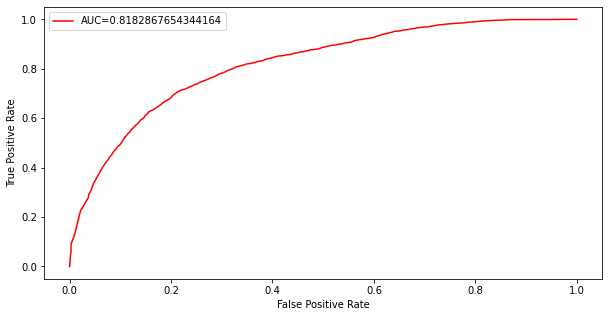

In [206]:
y_pred_proba_bag = bag.predict_proba(X_test)[::,1]

fpr_bag, tpr_bag, _ = roc_curve(y_test,  y_pred_proba_bag)
auc_bag = roc_auc_score(y_test,  y_pred_proba_bag)

plt.figure(figsize = (10,5))

plt.plot(fpr_bag, tpr_bag, color='red', label="AUC="+str(auc_bag))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.savefig("assets/pictures/CM_8_BAGGING_ROC_AUC.jpg")

plt.show()

### ROC-AUC Kriva

### Čuvanje modela proste agregacije

In [201]:
with open('models/classic_models/bag_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(bag, model_file)

# <span style="color:blue"> Uporedjivanje</span>

In [207]:
accuracies = [best_lr_acc, knn_acc, dtc_acc, best_rfc_acc, nb_acc, svc_acc, ab_acc, xgb_acc, bag_acc]
labels = ["Logistička regresija", "K najbližih suseda", "Stabla odlučivanja", "Slučajne šume", "Naivni bayes", "Metod potpornih vektora", "AdaBoost", "XGBoost", "Prosta agregacija"]

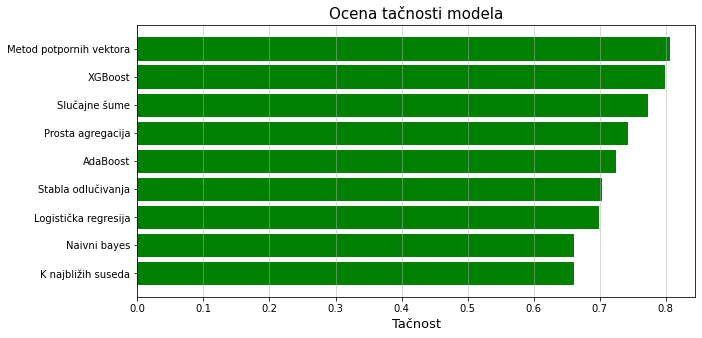

In [209]:
plt.figure(figsize = (10,5))

unsorted_list = [(labels, accuracies) for labels, accuracies in 
                  zip(accuracies, labels)]
sorted_list = sorted(unsorted_list) 

labels_sorted = []
accuracies_sorted = []

for i in sorted_list:
    labels_sorted += [i[1]]
    accuracies_sorted += [i[0]]
    
plt.title("Ocena tačnosti modela", fontsize=15)
plt.xlabel("Tačnost", fontsize=13)
plt.grid(axis = 'x', linewidth = 0.5)

plt.barh(labels_sorted, accuracies_sorted, color="green", edgecolor='green')

plt.savefig('assets/pictures/CM_Classification_models_comparisson.jpg')

plt.show()